In [342]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import mygene 
import random
import pysam
import glob
import re
#import genomeview
from pybedtools import BedTool, set_tempdir
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *
from tblout_parser import read_tbl
import sys
sys.path.insert(0,'/stor/home/cdw2854/cfNA/peak_callings')
from structural_peaks import peak_analyzer
from exon_cov import ExonFilter
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
plt.rc('font', **{'family':'sans-serif',
                  'sans-serif':'Arial'})
Peak_analyzer = peak_analyzer()
mrna_filter = mRNAFilter()
exon_filter = ExonFilter()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyboardInterrupt: 

In [277]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
set_tempdir(project_path)
peak_path = project_path + '/bed_files/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.filtered.tsv'
print(peak_tsv)
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)   
peak_df.head()

/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.filtered.tsv


,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
0,chr6,95156837,95156909,unfragmented.filtered.rvs_peak_23906,49831,1220.90051,4990.91406,4983.12256,1431.0,15.0,MTPAP,RBP,-,.,Unannotated,0.0,0.0,Sense
46879,chr16,223129,223709,unfragmented.filtered.rvs_peak_9743,22681,578.83380,2275.43311,2268.13550,778.0,15.0,.,Unannotated,-,HBA2,Long RNA,0.0,0.0,Antisense
46881,chr16,230338,230855,unfragmented.filtered.rvs_peak_9746,19008,478.68494,1907.96387,1900.81958,690.0,12.0,.,Unannotated,-,HBQ1,Long RNA,0.0,0.0,Antisense
46880,chr16,227335,227447,unfragmented.filtered.rvs_peak_9745,19796,526.54181,1986.90723,1979.65967,672.0,12.0,.,Unannotated,-,YBX3,RBP,0.0,0.0,Antisense
1,chr11,65273309,65273587,unfragmented.filtered.fwd_peak_5248,22296,532.33142,2237.13916,2229.68994,539.0,15.0,GTF2F1,RBP,+,TALAM1,Long RNA,0.0,0.0,Sense


In [278]:
peak_tsv

'/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.filtered.tsv'

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


Plotted:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_qc.pdf


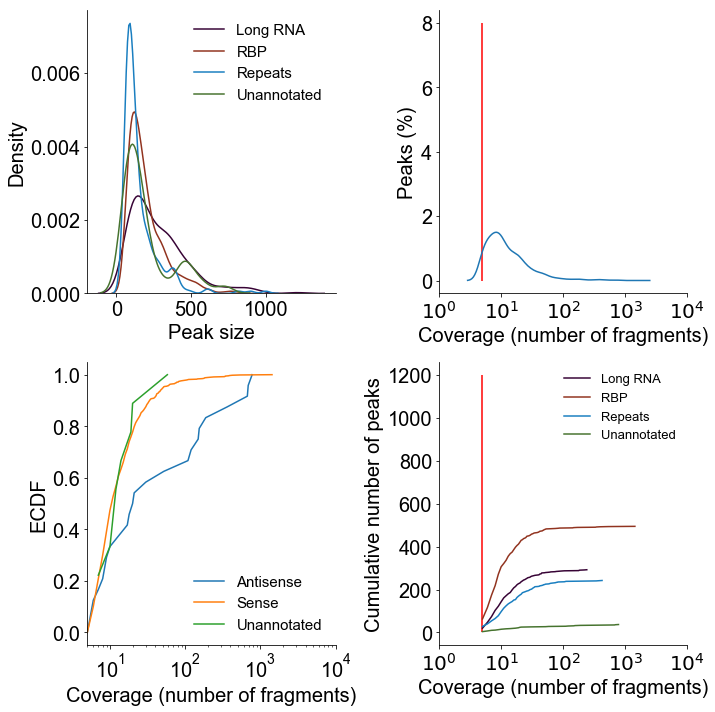

In [319]:
fig = plt.figure(figsize=(10,10))
size_ax = fig.add_subplot(221)
cov_ax = fig.add_subplot(222)
number_ax = fig.add_subplot(224)
dist_cov_ax = fig.add_subplot(223)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_size(peak_df, ax = size_ax)
size_ax.legend(fontsize=15, frameon=False)
plot_peak_coverage(peak_df, cov_ax, log=True)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [280]:
peak_df = peak_df\
    .query('sample_count >= %i & pileup >= %i' %(sample_cutoff, pileup_cutoff))\
    .assign(transcriptome = lambda d: list(map(transcriptome_map, d.chrom, d.start, d.end, d.strand)))\
    .assign(is_exon = lambda d: [mrna_filter.search(chrom, start, end, attribute = 'exon') for chrom, start, end in zip(d.chrom, d.start, d.end)]) \
    #.assign(is_transcriptome_peak = lambda d: [mrna_filter.search(chrom, start, end, attribute = 'transcriptome') for chrom, start, end in zip(d.chrom, d.start, d.end)])\
    #.pipe(lambda d: d[(d.is_exon=="no") | ((d.is_exon=="yes") & (d.is_transcriptome_peak=="yes"))])
peak_df.shape

(1065, 20)

In [281]:
peak_df.assign(l = lambda d: d.end-d.start).describe()#query('l == 998')

,start,end,score,fc,log10p,log10q,pileup,sample_count,pvalue,FDR,transcriptome,l
count,1.065000e+03,1.065000e+03,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1.065000e+03,1.065000e+03,1065.000000,1065.000000
mean,7.236416e+07,7.236438e+07,623.076056,22.350630,67.300469,62.355780,23.048826,7.779343,6.368707e-10,2.904928e-09,0.491473,212.005634
std,5.670767e+07,5.670766e+07,2323.938731,59.003477,232.694584,232.393803,69.270456,2.805262,9.529218e-09,4.205160e-08,0.313762,155.905076
min,1.000000e+04,1.021800e+04,30.000000,4.836510,6.659310,3.077590,5.000000,5.000000,0.000000e+00,0.000000e+00,0.000000,59.000000
25%,2.628536e+07,2.628550e+07,131.000000,7.855510,17.788620,13.158180,7.000000,5.000000,1.256927e-47,2.680288e-45,0.166667,100.000000
50%,5.774212e+07,5.774220e+07,206.000000,10.785000,25.492300,20.662760,10.000000,7.000000,3.218845e-26,3.057655e-24,0.600000,159.000000
75%,1.091019e+08,1.091021e+08,417.000000,18.580950,46.900690,41.758360,18.000000,9.000000,1.626972e-18,9.015406e-17,0.750000,275.000000
max,2.492400e+08,2.492402e+08,49831.000000,1220.900510,4990.914060,4983.122560,1431.000000,15.000000,2.191240e-07,9.556830e-07,1.000000,1207.000000


In [282]:
rbps = set()
for x in peak_df.query('sense_gtype=="RBP"').sense_gname.tolist():
    for rbp in x.split(','):
        rbps.add(rbp)
len(rbps)

90

No handles with labels found to put in legend.


Saved: /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_figure.pdf


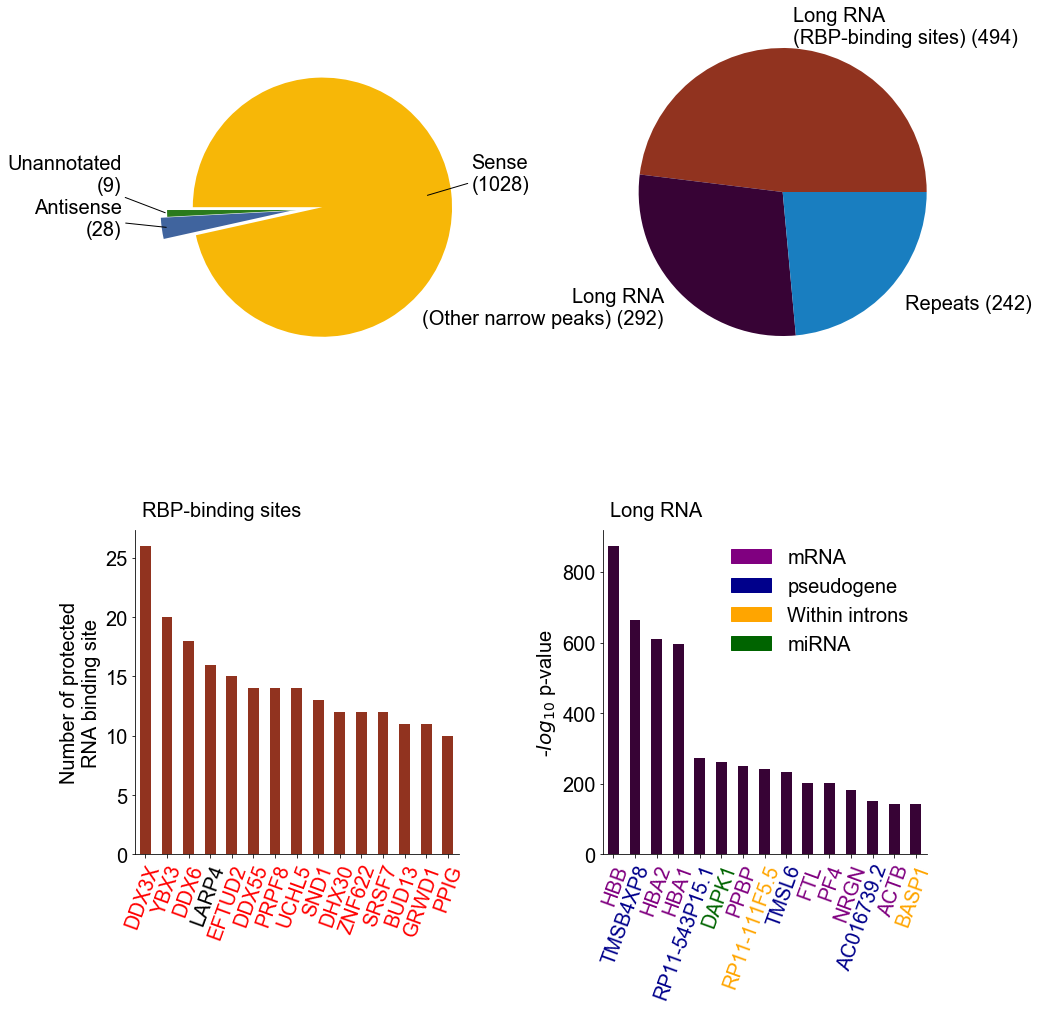

In [283]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.52, 0.45, 0.45])
pie_ax = fig.add_axes([0.55, 0.52, 0.5, 0.5])
#rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
#long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
rbp_ax = fig.add_axes([-0.1, -0.15, 0.45, 0.45])
long_ax = fig.add_axes([0.55, -0.15, 0.45, 0.45])

#misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
#plot_repeats_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
new_ce = color_encoder()
new_ce.encoder = {'mRNA':'purple',
                 'pseudogene':'darkblue',
                 'Within introns':'orange', 
                 'miRNA':'darkgreen'}
for xt in  long_ax.get_xticklabels():
    if xt.get_text() in {'HBB','HBA2','HBA1','PPBP','PF4','FTL','NRGN','ACTB'}:
        xt.set_color(new_ce.encoder['mRNA'])
    elif xt.get_text() in {'TMSB4XP8','TMSL6','AC016739.2','RP11-543P15.1',
                          'RP11-3P17.3'}:
        xt.set_color(new_ce.encoder['pseudogene'])
    elif xt.get_text() in 'DAPK1':
        xt.set_color(new_ce.encoder['miRNA'])
    else:
        xt.set_color(new_ce.encoder['Within introns'])
new_ce.show_legend(ax = long_ax, frameon=False, fontsize=20)
fig.text(-0.09,0.32, 'RBP-binding sites', fontsize=20)
fig.text(0.56,0.32, 'Long RNA', fontsize=20)
#fig.text(0.85,0.5, 'Repeats', fontsize=18)

figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [329]:
peak_df\
    .query('sense_gtype=="Long RNA"')\
    .sort_values('log10p', ascending=False)\
    .filter(['chrom','start','end','sense_gname','peakname'])\
    .head(20)\
    .assign(is_exon = Peak_analyzer)

,chrom,start,end,sense_gname,peakname
8,chr11,5247806,5248342,HBB,unfragmented.filtered.rvs_peak_4216
9,chr11,5246693,5246957,HBB,unfragmented.filtered.rvs_peak_4215
11,chr4,91759630,91760267,AC019188.1,unfragmented.filtered.rvs_peak_20781
12,chr16,222873,223709,HBA2,unfragmented.filtered.fwd_peak_10357
13,chr16,226677,227521,HBA1,unfragmented.filtered.fwd_peak_10358
20,chr12,3320773,3321119,RP11-543P15.1,unfragmented.filtered.rvs_peak_5660
22,chr9,90294212,90294292,DAPK1,unfragmented.filtered.fwd_peak_30031
24,chr4,74853681,74853911,PPBP,unfragmented.filtered.rvs_peak_20632
26,chr9,46727655,46727777,RP11-111F5.5,unfragmented.filtered.fwd_peak_29822
28,chr20,49456749,49457280,TMSL6,unfragmented.filtered.rvs_peak_17009


In [357]:
needed_columns = ['chrom','start','end','peakname','score','strand']
needed_columns.extend(list(set(peak_df.columns.tolist()) - set(needed_columns)))
exon_filtered_peaks = peak_df\
    .filter(needed_columns)
exon_filtered_peaksr = exon_filter.filter(exon_filtered_peaks)

Filtered out 0 peaks


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


In [ ]:
exon_filter = ExonFilter()

# Intron #

In [285]:
import pymysql

connection = pymysql.connect(host='genome-mysql.cse.ucsc.edu',
                             user='genome',
                             password='',
                             cursorclass=pymysql.cursors.DictCursor)

query = "SELECT DISTINCT knownGene.name, kgXref.geneSymbol "\
        " FROM hg19.knownGene INNER JOIN hg19.kgXref ON "\
        " knownGene.name = kgXref.kgID  ;"
ucsc_id = pd.read_sql(query, connection) \
    .rename(columns = {'name':'gene_name'})
ucsc_id.head()

,gene_name,geneSymbol
0,uc001aaa.3,DDX11L1
1,uc010nxr.1,DDX11L1
2,uc010nxq.1,DDX11L1
3,uc001aal.1,OR4F5
4,uc001aaq.2,DQ597235


In [307]:
from miRNA_tools import miRNA_test, test_mirtron, fold_intron, gene_conversion
mitest = miRNA_test()
gc = gene_conversion()
pkd = {'RP11-958N24.1':'PKD1P3',
        'RP11-958N24.2':'PKD1P5',
        'RP11-1212A22.1':'PKD1P2',
        'RP11-1212A22.4':'PKD1P4'}


full_peak = pd.read_csv(peak_path + '/unfragmented.unfiltered.tsv', sep='\t')\
    .query('sample_count >= %i & pileup >= %i' %(sample_cutoff, pileup_cutoff))
columns = full_peak.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand','overlapped'])
intron_df = BedTool()\
    .from_dataframe(full_peak)\
    .intersect('/stor/work/Lambowitz/ref/hg19_ref/genes/introns.gencode.bed.gz', 
               f= 0.5,F=0.95,wao=True)\
    .to_dataframe(names = columns) \
    .reset_index(drop=True)\
    .query('intron_chrom != "."')\
    .assign(tid = lambda d: d.intron_gene.str.extract('(ENST[0-9]+)\.',expand=False))\
    .merge(gc.trans.assign(tid = lambda d: d.tid.str.extract('(ENST[0-9]+)',expand=False)), 
           on ='tid', how='left') \
    .assign(gsymbol = lambda d: np.where(d.gsymbol.isin(pkd.keys()),
                                         d.gsymbol.map(pkd),
                                         d.gsymbol))\
    .assign(fulllength = lambda d: list(map(mrna_filter.fragment_test, d.chrom, d.intron_start, d.intron_end, d.intron_strand)))\
    .query('fulllength > 0 ')
intron_df.shape

***** WARNING: File /stor/work/Lambowitz/ref/hg19_ref/genes/introns.gencode.bed.gz has inconsistent naming convention for record:
GL000192.1	430271	438553	ENST00000621489.1_1	2	-

***** WARNING: File /stor/work/Lambowitz/ref/hg19_ref/genes/introns.gencode.bed.gz has inconsistent naming convention for record:
GL000192.1	430271	438553	ENST00000621489.1_1	2	-

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


(225, 25)

In [308]:
full_peak.query('peakname == "unfragmented.unfiltered.fwd_peak_14005"')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype
1597,chr19,17316961,17317050,unfragmented.unfiltered.fwd_peak_14005,196,10.66985,24.21737,19.67003,10.0,6.0,MYO9B,Long RNA,+,.,.


In [309]:
intron_df[intron_df.gsymbol.str.contains('PKD')]

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand,overlapped,tid,gsymbol,fulllength
10,chr16,16468913,16469003,unfragmented.unfiltered.fwd_peak_10553,1181,44.32756,123.22947,118.15022,45.0,13.0,...,chr16,16468913,16469003,ENST00000532739.1_1,27,+,90,ENST00000532739,PKD1P5,40
12,chr16,18430617,18430707,unfragmented.unfiltered.rvs_peak_9828,1105,42.94662,115.51879,110.53565,44.0,15.0,...,chr16,18430617,18430707,ENST00000525846.6_1,28,-,90,ENST00000525846,PKD1P2,43
14,chr16,15027133,15027223,unfragmented.unfiltered.fwd_peak_10533,979,39.05211,102.93088,97.90172,40.0,13.0,...,chr16,15027133,15027223,ENST00000534164.5_1,27,+,90,ENST00000534164,PKD1P3,39
16,chr16,2149771,2149861,unfragmented.unfiltered.rvs_peak_9609,868,33.87155,91.73558,86.81598,34.0,11.0,...,chr16,2149771,2149861,ENST00000262304.8_1,30,-,90,ENST00000262304,PKD1,33
17,chr16,2149771,2149861,unfragmented.unfiltered.rvs_peak_9609,868,33.87155,91.73558,86.81598,34.0,11.0,...,chr16,2149771,2149861,ENST00000415938.7_1,16,-,90,ENST00000415938,PKD1,33
18,chr16,2149771,2149861,unfragmented.unfiltered.rvs_peak_9609,868,33.87155,91.73558,86.81598,34.0,11.0,...,chr16,2149771,2149861,ENST00000423118.5_1,30,-,90,ENST00000423118,PKD1,33
19,chr16,2149771,2149861,unfragmented.unfiltered.rvs_peak_9609,868,33.87155,91.73558,86.81598,34.0,11.0,...,chr16,2149771,2149861,ENST00000471603.6_1,8,-,90,ENST00000471603,PKD1,33
20,chr16,2149771,2149861,unfragmented.unfiltered.rvs_peak_9609,868,33.87155,91.73558,86.81598,34.0,11.0,...,chr16,2149771,2149861,ENST00000480227.5_1,8,-,90,ENST00000480227,PKD1,33
21,chr16,2149771,2149861,unfragmented.unfiltered.rvs_peak_9609,868,33.87155,91.73558,86.81598,34.0,11.0,...,chr16,2149771,2149861,ENST00000483731.5_1,18,-,90,ENST00000483731,PKD1,33
22,chr16,2149771,2149861,unfragmented.unfiltered.rvs_peak_9609,868,33.87155,91.73558,86.81598,34.0,11.0,...,chr16,2149771,2149861,ENST00000486339.6_1,13,-,90,ENST00000486339,PKD1,33


In [310]:
intron_df.assign(l = lambda d: d.intron_end - d.intron_start).query('l==134')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,intron_start,intron_end,intron_gene,intron_score,intron_strand,overlapped,tid,gsymbol,fulllength,l
198,chr11,67068618,67068872,unfragmented.unfiltered.fwd_peak_5251,157,10.25929,20.18605,15.72143,10.0,8.0,...,67068618,67068752,ENST00000308440.10_1,12,+,134,ENST00000308440,ANKRD13D,9,134
199,chr11,67068618,67068872,unfragmented.unfiltered.fwd_peak_5251,157,10.25929,20.18605,15.72143,10.0,8.0,...,67068618,67068752,ENST00000447274.6_1,11,+,134,ENST00000447274,ANKRD13D,9,134
200,chr11,67068618,67068872,unfragmented.unfiltered.fwd_peak_5251,157,10.25929,20.18605,15.72143,10.0,8.0,...,67068618,67068752,ENST00000507915.1_1,2,+,134,ENST00000507915,ANKRD13D,9,134
201,chr11,67068618,67068872,unfragmented.unfiltered.fwd_peak_5251,157,10.25929,20.18605,15.72143,10.0,8.0,...,67068618,67068752,ENST00000511455.6_1,11,+,134,ENST00000511455,ANKRD13D,9,134
202,chr11,67068618,67068872,unfragmented.unfiltered.fwd_peak_5251,157,10.25929,20.18605,15.72143,10.0,8.0,...,67068618,67068752,ENST00000512231.5_1,4,+,134,ENST00000512231,ANKRD13D,9,134
203,chr11,67068618,67068872,unfragmented.unfiltered.fwd_peak_5251,157,10.25929,20.18605,15.72143,10.0,8.0,...,67068618,67068752,ENST00000513750.5_1,4,+,134,ENST00000513750,ANKRD13D,9,134
204,chr11,67068618,67068872,unfragmented.unfiltered.fwd_peak_5251,157,10.25929,20.18605,15.72143,10.0,8.0,...,67068618,67068752,ENST00000514166.5_1,10,+,134,ENST00000514166,ANKRD13D,9,134
205,chr11,67068618,67068872,unfragmented.unfiltered.fwd_peak_5251,157,10.25929,20.18605,15.72143,10.0,8.0,...,67068618,67068752,ENST00000515828.1_1,1,+,134,ENST00000515828,ANKRD13D,9,134


In [311]:
intron_df.assign(l = lambda d: d.intron_end - d.intron_start).describe()

,start,end,score,fc,log10p,log10q,pileup,sample_count,intron_start,intron_end,intron_score,overlapped,fulllength,l
count,2.250000e+02,2.250000e+02,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,2.250000e+02,2.250000e+02,225.000000,225.000000,225.000000,225.000000
mean,6.703174e+07,6.703184e+07,591.093333,22.745527,63.793173,59.154161,22.520000,8.244444,6.703174e+07,6.703183e+07,9.444444,93.440000,16.697778,93.675556
std,5.795720e+07,5.795720e+07,1435.819233,39.247044,143.765756,143.575997,40.671383,3.001157,5.795720e+07,5.795720e+07,8.485691,16.722451,31.105340,16.756837
min,7.184110e+05,7.184880e+05,69.000000,5.762270,11.179730,6.972830,5.000000,5.000000,7.184110e+05,7.184870e+05,1.000000,71.000000,1.000000,71.000000
25%,1.847072e+07,1.847081e+07,137.000000,8.589320,18.151720,13.770430,8.000000,6.000000,1.847072e+07,1.847081e+07,3.000000,80.000000,5.000000,80.000000
50%,5.471737e+07,5.471747e+07,286.000000,13.652530,33.270820,28.619090,13.000000,7.000000,5.471736e+07,5.471747e+07,7.000000,90.000000,10.000000,90.000000
75%,1.000337e+08,1.000338e+08,597.000000,23.528180,64.548500,59.730370,23.000000,11.000000,1.000337e+08,1.000338e+08,12.000000,102.000000,21.000000,102.000000
max,2.200887e+08,2.200888e+08,13939.000000,376.595250,1399.635130,1393.902340,390.000000,15.000000,2.200887e+08,2.200888e+08,46.000000,134.000000,322.000000,134.000000


In [312]:
confirmed_intron = intron_df \
    .query('sample_count >= 5 & pileup >=5 & fulllength > 0')\
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.intron_start, d.intron_end, d.strand))) \
    .assign(seq = lambda d: d.seq.str.upper())\
    .groupby(['chrom','start','end','intron_start','intron_end',
             'strand','peakname','sense_gname','sample_count','pileup','seq'], as_index=False)\
    .agg({'gsymbol': lambda x: x.head(1)})\
    .reset_index(drop=True) \
    .assign(size = lambda d: d.end - d.start) \
    .assign(miRNA = lambda d: list(map(mitest.test, d.chrom, d.start, d.end))) \
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))\
    .assign(l = lambda d: -d.intron_start+d.intron_end) 
confirmed_intron.head()

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,seq,gsymbol,size,miRNA,dinucleotide,l
0,chr1,54717368,54717466,54717365,54717466,-,unfragmented.unfiltered.rvs_peak_922,RBM22,6.0,8.0,GTAGAGAGGGCAGGGTGGGCCTAGGGTGGCTGGGGATGCCAGGAGG...,SSBP3,98,No,GT:AG,101
1,chr1,155288543,155288646,155288544,155288646,+,unfragmented.unfiltered.fwd_peak_1874,RPS5,8.0,16.0,GTGAGGGGAGGTGAGGGACAGCGCGAACCATGTCTGGACAGCGAGG...,FDPS,103,No,GT:AG,102
2,chr1,161022152,161022229,161022153,161022229,-,unfragmented.unfiltered.rvs_peak_1753,ARHGAP30,13.0,31.0,GTAAGTCTGGGGAGATGGGGGGAGCTCTGCTGAGGGTGCACAAGGC...,ARHGAP30,77,No,GT:AG,76
3,chr11,45944515,45944608,45944515,45944608,+,unfragmented.unfiltered.fwd_peak_4964,EFTUD2,10.0,23.0,GTGGGGACCTGGGGTGTGAGCGCCGCGAGCCTGGCGGGCGAGCGGG...,GYLTL1B,93,No,GT:AG,93
4,chr11,62370150,62370230,62370150,62370230,-,unfragmented.unfiltered.rvs_peak_4676,TROVE2,6.0,7.0,GTGAGGCCGCGGGGATCGCCGGGGTGGGACCGGTGGGCCCGAGGGC...,EML3,80,No,GT:AG,80


In [313]:
pd.read_csv('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/supp_tab_intron.tsv',
           sep='\t')\
    .query('peak_name == "chr19:17316961-17317050"')

,peak_name,is_sense,gname,sense_gtype,strand,fragment_count,sample_count,seq,energy,concensus_seq,concensus_fold,concensus_energy,force_cloverleaf,is_intron
312,chr19:17316961-17317050,Sense,MYO9B,Long RNA,+,10.0,6.0,GTGGGCGCTGTGGGCAGGTGGGTGCAGTGCCAGGCCCCAGGCACAG...,-45.799999,GTGGGCGCTGTGGGCAGGTGGGTGCAGTGCCAGGCCCCAGGCACAG...,[],-45.799999,(((((....(((((..((((((((..(((((........)))))((...,full-length intron


In [316]:
pd.read_csv('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/supp_tab_intron.tsv',
           sep='\t')\
    .query('is_intron!="."') \
    .filter(['peak_name','gname'])\
    .assign(filtered='filteted')\
    .merge(confirmed_intron\
                .assign(peak_name = lambda d: d.chrom + ':'+d.start.astype(str)+'-'+d.end.astype(str))\
                .assign(unfilter = 'unfiltered')\
                .filter(['peak_name','unfilter','chrom','start','end','miRNA']),
          how ='outer')

,peak_name,gname,filtered,unfilter,chrom,start,end,miRNA
0,chr19:11333579-11333670,EFTUD2,filteted,unfiltered,chr19,11333579.0,11333670.0,No
1,chr11:63978562-63978746,DDX24,filteted,unfiltered,chr11,63978562.0,63978746.0,No
2,chr17:39913787-39913887,XPO5,filteted,unfiltered,chr17,39913787.0,39913887.0,No
3,chr16:16468913-16469003,RP11-958N24.2,filteted,unfiltered,chr16,16468913.0,16469003.0,No
4,chr16:18430617-18430707,RP11-1212A22.1,filteted,unfiltered,chr16,18430617.0,18430707.0,No
5,chr16:15027133-15027223,RP11-958N24.1,filteted,unfiltered,chr16,15027133.0,15027223.0,No
6,chr16:2149771-2149861,EFTUD2,filteted,unfiltered,chr16,2149771.0,2149861.0,No
7,chr16:16425620-16425710,PKD1P1,filteted,unfiltered,chr16,16425620.0,16425710.0,No
8,chr1:161022152-161022229,ARHGAP30,filteted,unfiltered,chr1,161022152.0,161022229.0,No
9,chr16:18470719-18470809,RP11-1212A22.4,filteted,unfiltered,chr16,18470719.0,18470809.0,No


In [317]:
confirmed_intron.query('miRNA=="Yes"')

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,seq,gsymbol,size,miRNA,dinucleotide,l
12,chr16,2140194,2140285,2140195,2140285,-,unfragmented.unfiltered.rvs_peak_9608,MIR1225,5.0,10.0,GTGGGTACGGCCCAGTGGGGGGGAGAGGGACACGCCCTGGGCTCTG...,PKD1,91,Yes,GT:AG,90
20,chr16,28855177,28855270,28855176,28855270,-,unfragmented.unfiltered.rvs_peak_9969,MIR4721,10.0,23.0,GTGAGGGCTCCAGGTGACGGTGGGCAGGGTTGAGCCAAGCTCTCCC...,TUFM,93,Yes,GT:AG,94
25,chr19,2434911,2435053,2434911,2434998,-,unfragmented.unfiltered.rvs_peak_12601,MIR7108,9.0,12.0,GTGTGGCCGGCAGGCGGGTGGGCGGGGGCGGCCGGTGGGAACCCCG...,LMNB2,142,Yes,GT:AG,87
32,chr2,220088744,220088827,220088744,220088827,-,unfragmented.unfiltered.rvs_peak_15687,AC068946.1,12.0,28.0,GTGGGCCAGGGCCACAGGCGGGAGCAAGCCGGCTAGCATTCCTGGG...,ATG9A,83,Yes,GT:AG,83
34,chr22,50356513,50356589,50356513,50356587,+,unfragmented.unfiltered.fwd_peak_19202,MIR6821,14.0,122.0,GTGCGTGGTGGCTCGAGGCGGGGGTGGGGGCCTCGCCCTGCTTGGG...,PIM3,76,Yes,GT:AG,74
37,chr6,31323000,31323093,31323000,31323093,-,unfragmented.unfiltered.rvs_peak_22699,MIR6891,11.0,19.0,GTAAGGAGGGGGATGAGGGGTCATATCTCTTCTCAGGGAAAGCAGG...,HLA-B,93,Yes,GT:AG,93
40,chr6,31924615,31924718,31924615,31924717,-,unfragmented.unfiltered.rvs_peak_22719,MIR1236,12.0,23.0,GTGAGTGACAGGGGAAATGGGGATGGACTGGAAGTGGGCAGCATGG...,NELFE,103,Yes,GT:AG,102


In [318]:
confirmed_intron.shape

(48, 16)

In [239]:
confirmed_intron.query('l >150').sort_values('l')

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,seq,gsymbol,size,miRNA,dinucleotide,l


In [240]:
seq_dict = defaultdict(list)
for i, row in confirmed_intron.iterrows():
    seq_dict[row['seq']].append(row['chrom']+ ':' + \
                                str(row['start']) + '-'+\
                                str(row['end']) + '('+ \
                                row['sense_gname'] + ')')

In [241]:
list(filter(lambda x: len(x[1])>1,  seq_dict.items()))

[('GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTCCTGCCCCTCAGCCTCACCTGTGTGGCCTCCTCTCCTCCACACAG',
  ['chr16:15027133-15027223(RP11-958N24.1)',
   'chr16:15221453-15221543(RP11-1186N24.5)',
   'chr16:16425620-16425710(PKD1P1)',
   'chr16:16468913-16469003(RP11-958N24.2)',
   'chr16:18430617-18430707(RP11-1212A22.1)',
   'chr16:18470719-18470809(RP11-1212A22.4)'])]

In [242]:
confirmed_intron.query('miRNA == "Yes"')

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,seq,gsymbol,size,miRNA,dinucleotide,l


In [243]:
mirtron = confirmed_intron\
    .groupby('seq', as_index=False)\
    .apply(lambda d: d.nlargest(1,'pileup'))\
    .reset_index(drop=True) \
    .assign(fold = lambda d: d.seq.map(fold_intron))\
    .assign(mirtron_type = lambda d: d.fold.map(test_mirtron)) \
    .assign(fold_abstract = lambda d: d.fold.map(Peak_analyzer.abstract_structure))

In [244]:
mirtron.groupby('mirtron_type').count()

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,seq,gsymbol,size,miRNA,dinucleotide,l,fold,fold_abstract
mirtron_type,,,,,,,,,,,,,,,,,,
3-trim,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25
5-trim,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Both trim,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Conventional,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6


In [245]:
confirmed_intron.query('sense_gname == "PRPF8"').seq.tolist()

['GTGAGAGGCTGGGCACAGGCAGCGGGAGGACCTCAGGCATGGCACCCTCCCTCAGCGCAGTCCCTGGAGAGCTGCAGGGGCCGGAGGCACAGGTGGCTCTCCGCCAGGGCTCAGGCGTGGCTGTCTTCTCACAG',
 'GTGAGTGGCCACCATGCGGGGACAGGGGCAGGGGCAGCCCTCACCCACAGCCTCTCACCTGCCTTTGTCCACCCACAG',
 'GTGAGGCTGGGGGGAGGCATAGGTCTTGGCACAGGGAAGTAGAGTTTGGGAGACTCGGCCGTCTGGAGCCTTGTTTCTAACTCACTCCCGCCCTCAAACCTCCGCGGCCTCCCGGACTCAG',
 'GTGGGTAGGGGCATCTCCAAGGCGGTGGGGGCTGTGGCTCCCAGCGGATGACTCTGAGCGGCTCCTTCCCCAG',
 'GTAAGCAGCTCGTCCCAGCCCTGGGCTCCTGGCTGCCCGCCCAGGATACCTGTCTGACTCACCCTGGGCGCTGGGCTCTGGCTGTTTCCAG']

In [246]:
tablename = figure_path + '/intron_table.csv'
confirmed_intron \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

Written:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/intron_table.csv


In [247]:
confirmed_intron

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,seq,gsymbol,size,miRNA,dinucleotide,l
0,chr1,54717368,54717466,54717365,54717466,-,unfragmented.filtered.rvs_peak_944,RBM22,6.0,8.0,GTAGAGAGGGCAGGGTGGGCCTAGGGTGGCTGGGGATGCCAGGAGG...,SSBP3,98,No,GT:AG,101
1,chr1,155288543,155288646,155288544,155288646,+,unfragmented.filtered.fwd_peak_1889,RPS5,8.0,16.0,GTGAGGGGAGGTGAGGGACAGCGCGAACCATGTCTGGACAGCGAGG...,FDPS,103,No,GT:AG,102
2,chr1,161022152,161022229,161022153,161022229,-,unfragmented.filtered.rvs_peak_1766,ARHGAP30,13.0,31.0,GTAAGTCTGGGGAGATGGGGGGAGCTCTGCTGAGGGTGCACAAGGC...,ARHGAP30,77,No,GT:AG,76
3,chr11,45944515,45944608,45944515,45944608,+,unfragmented.filtered.fwd_peak_5019,EFTUD2,10.0,23.0,GTGGGGACCTGGGGTGTGAGCGCCGCGAGCCTGGCGGGCGAGCGGG...,GYLTL1B,93,No,GT:AG,93
4,chr11,62370150,62370230,62370150,62370230,-,unfragmented.filtered.rvs_peak_4768,TROVE2,6.0,7.0,GTGAGGCCGCGGGGATCGCCGGGGTGGGACCGGTGGGCCCGAGGGC...,EML3,80,No,GT:AG,80
5,chr11,63978562,63978746,63978643,63978746,+,unfragmented.filtered.fwd_peak_5199,DDX24,14.0,143.0,GTGAGTGCAAGTGGGGGTGGGCCTGGGGGGTTGGGGGCAGGGGCCG...,FERMT3,184,No,GT:AG,103
6,chr11,67068618,67068753,67068618,67068752,+,unfragmented.filtered.fwd_peak_5307,PRPF8,7.0,10.0,GTGAGAGGCTGGGCACAGGCAGCGGGAGGACCTCAGGCATGGCACC...,ANKRD13D,135,No,GT:AG,134
7,chr11,71715145,71715270,71715145,71715270,-,unfragmented.filtered.rvs_peak_4972,NUMA1,5.0,6.0,GTGAGGCTGGGGCTGAAGGGGGATGAAGCGACGCCCTGGCGGGACC...,NUMA1,125,No,GT:AG,125
8,chr14,106208132,106208229,106208132,106208229,-,unfragmented.filtered.rvs_peak_8745,IGHG1,7.0,15.0,GTGGGACCCGTGGGGTGCGAGGGCCACATGGACAGAGGCCGGCTCG...,IGHG1,97,No,GT:AG,97
9,chr15,91423004,91423098,91423004,91423096,+,unfragmented.filtered.fwd_peak_10230,XPO5,12.0,30.0,GTGAGGGCAGGCTGGCCCGGCAGGCTGGATGTGGAGTTAGGTAGAA...,FURIN,94,No,GT:AG,92


In [248]:
seqfile = peak_path  + '/unfragmented.intron.fa'
used = defaultdict(int)
with open(seqfile, 'w')  as fa:
    for i, row in confirmed_intron\
            .query('pileup >= 4 & sample_count >= 5' )\
            .filter(['seq','gsymbol','sense_gname'])\
            .drop_duplicates()\
            .iterrows():
        name = row['gsymbol']
        used[name] += 1
        if used[name] > 1:
            print(name, row['sense_gname'])
            name = name + '-%i' %(used[name])
        print('>%s\n%s' %(name, row['seq']), file = fa)
os.system('cat {seqfile} | muscle > {multifile}'.format(seqfile=seqfile,
                                                                 multifile = seqfile.replace('.fa','.multi.fa')))
print('Written: %s' % seqfile.replace('.fa','.multi.fa'))

PKD1P5 RP11-1212A22.4
Written: /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.intron.multi.fa
